# Simplified Job Scheduling Problem Explained

## 1. Introduction: The Challenge of Scheduling

Scheduling problems are common in many industries and real-world scenarios. The general goal is to assign tasks (or "jobs") to available resources (like "machines" or workers) over time, respecting various constraints, to achieve a specific objective (like minimizing cost or completion time).

These problems can become very complex quickly due to:

* **Combinatorial Nature:** There are often vast numbers of possible schedules.
* **Constraints:** Rules like resource availability, task dependencies (precedence), deadlines, and setup times add layers of difficulty.

Examples include factory production planning, project task management, logistics routing, and operating system task scheduling. Mathematical optimization provides a powerful framework for finding optimal or near-optimal solutions to these challenging problems.

## 2. Focusing on: Parallel Machine Scheduling Problem (PMSP)

In this notebook, we will focus on a fundamental and widely applicable type of scheduling problem known as the **Parallel Machine Scheduling Problem (PMSP)**.

**The PMSP Setup:**

* We have multiple independent **Jobs**. Each job represents a single task that needs to be done.
* We have multiple identical (or related) **Machines** operating in parallel.
* Each job `i` has a specific **Processing Time** (`JT[i]`) required to complete it, regardless of which machine it runs on.
* Each job must be assigned to **exactly one** machine.
* Machines can process multiple jobs, but **only one job at a time**.


**The Goal (Objective):**

Our primary objective is to **Minimize the Makespan**.

* **Makespan:** The time when the *last* job finishes across *all* machines. This is determined by the machine that takes the longest to complete all jobs assigned to it.
* **Objective:** Find an assignment of jobs to machines such that the completion time of the busiest machine is minimized. This effectively balances the workload across the available machines.

This notebook will demonstrate how to model and solve this PMSP using the JijModeling and OMMX-Adapter.


## 3. Problem Components (PMSP)

Let's define the key elements for our PMSP model:

* **Jobs:** A set of independent tasks to be scheduled (indexed `i = 0, 1, ..., N-1`).
* **Machines:** A set of parallel resources available to process the jobs (indexed `m = 0, 1, ..., M-1`).
* **Processing Times (`JT[i]`):** The time required to complete job `i` on any machine.

## 4. Objective Function (Minimize Makespan)

As stated, the goal is to minimize the makespan, which is the maximum completion time among all machines.


## 5. Key Constraints (PMSP)

To ensure a valid schedule, we need two main types of constraints:

1.  **Job Assignment Constraint:** Every job must be assigned to exactly one machine.
    * Mathematically: For each job `i`, the sum of assignments `x[i, m]` over all machines `m` must equal 1.
2.  **Makespan Constraint:** The makespan must be greater than or equal to the total processing time (load) on *any* given machine `m`.
    * Mathematically: For each machine `m`, the sum of processing times `JT[i]` for all jobs `i` assigned to it (`JT[i] * x[i, m]`) must be less than or equal to the `makespan` variable.

By minimizing the `makespan` variable subject to these constraints, the optimizer is forced to find an assignment that balances the load and thus minimizes the maximum load.


## 6. Mathematical Model Definition (JijModeling)

Now, let's express this PMSP using JijModeling.

In [1]:
# Import necessary libraries
import jijmodeling as jm

# --- 1. Placeholders (Input Data) ---
# JT[i]: Processing time for job i
JT = jm.Placeholder("JT", ndim=1, description="Processing time for job i")
# N: Number of jobs (derived from the length of JT)
N = JT.len_at(0, latex="N", description="Number of jobs")
# M: Number of machines
M = jm.Placeholder("M", description="Number of machines")

# --- 2. Elements (Indices) ---
# i: Index for jobs (from 0 to N-1)
i = jm.Element("i", belong_to=(0, N), description="Index for jobs")
# m: Index for machines (from 0 to M-1)
m = jm.Element("m", belong_to=(0, M), description="Index for machines")

# --- 3. Variables (Decision and Auxiliary) ---
# x[i, m]: Binary variable, 1 if job i is assigned to machine m, 0 otherwise
x = jm.BinaryVar(
    "x",
    shape=(N, M),
    description="x[i, m]: 1 if job i is assigned to machine m, else 0",
)
# makespan: Continuous variable representing the maximum completion time across all machines
makespan = jm.ContinuousVar(
    "makespan",
    lower_bound=0,
    upper_bound=jm.sum(i, JT[i]),
    description="Makespan: The completion time of the last job across all machines",
)

# --- 4. Problem Definition ---
problem = jm.Problem("Parallel Machine Scheduling")

# --- 5. Constraints ---
# Constraint 1: Each job 'i' must be assigned to exactly one machine 'm'.
problem += jm.Constraint(
    "Job_Assignment",
    jm.sum(m, x[i, m]) == 1,
    forall=i,
)
# Constraint 2: The total processing time on any machine 'm' must be less than or equal to the makespan.
problem += jm.Constraint(
    "Max_Time_per_Machine",
    jm.sum(i, JT[i] * x[i, m]) <= makespan,
    forall=m,
)

# --- 6. Objective Function ---
# Minimize the makespan.
problem += makespan

problem

The code above defines the mathematical model for the Parallel Machine Scheduling Problem.

* `x[i, m]` represents the core **decision**: which machine gets which job.
* `makespan` represents the overall schedule **performance** (completion time) we want to minimize.
* The `Job_Assignment` constraint ensures every job is processed.
* The `Max_Time_per_Machine` constraint links the assignments to the makespan, ensuring the makespan is large enough to accommodate the busiest machine. Minimizing `makespan` then implicitly balances the load.

## 7. Preparing Instance Data

Next, we define a specific instance of the problem: the processing times for a set of jobs and the number of available machines.

In [2]:
# Example: 10 jobs with their respective processing times
job_times_data = [5, 8, 3, 6, 9, 4, 7, 5, 2, 8]
# Example: 3 machines are available
num_machines_data = 3

# Prepare the data in the dictionary format required by JijModeling Placeholders
instance_data = {
    "JT": job_times_data,
    "M": num_machines_data,
}

print("Instance Data:")
print(f"  Job Processing Times (JT): {instance_data['JT']}")
print(f"  Number of Machines (M): {instance_data['M']}")
print(f"  Number of Jobs (N derived): {len(instance_data['JT'])}")

Instance Data:
  Job Processing Times (JT): [5, 8, 3, 6, 9, 4, 7, 5, 2, 8]
  Number of Machines (M): 3
  Number of Jobs (N derived): 10


## 8. Solving the Instance with a Solver

We now use a solver compatible with JijModeling to find the optimal solution for the defined model and instance data.
Here, we'll use the SCIP interface provided by the `ommx-pyscipopt-adapter` package.


In [3]:
# Import the necessary adapter and interpreter
import ommx_pyscipopt_adapter as scip_ad

# 1. Create an Interpreter to evaluate the problem with specific instance data
interpreter = jm.Interpreter(instance_data)
# 2. Evaluate the problem to create a concrete instance for the solver
instance = interpreter.eval_problem(problem)

# 3. Solve the instance using the OMMX SCIP Adapter
solution = scip_ad.OMMXPySCIPOptAdapter.solve(instance)

## 9. Interpreting and Displaying Results

Now, we process the `solution` object returned by the solver adapter to extract the optimal makespan and the job assignments.

In [4]:
x_result: dict[tuple[int, ...], float] = solution.extract_decision_variables("x")

In [5]:
import pandas as pd

optimal_makespan = solution.objective
print(f"\n--- Solver Results ---")
print(f"Optimal Makespan: {optimal_makespan:.2f}")
assignment = {}  # {machine_idx: [job_idx, ...]}
assigned_jobs_flat = (
    []
)  # To store data for DataFrame: [{'Job': i, 'Machine': m, 'Time': t}]
x_result = {}

x_result = solution.extract_decision_variables("x")

# Process the extracted x_result dictionary
num_machines_instance = instance_data["M"]
for indices, val in x_result.items():
    # indices should be a tuple like (i, m)
    if len(indices) == 2 and val > 0.5:  # Check for binary '1'
        i, m = indices  # Unpack the indices
        if m not in assignment:
            assignment[m] = []
        assignment[m].append(i)
        # Ensure job index i is valid before accessing JT
        if 0 <= i < len(instance_data["JT"]):
            assigned_jobs_flat.append(
                {"Job": i, "Machine": m, "Time": instance_data["JT"][i]}
            )
        else:
            print(
                f"Warning: Invalid job index {i} found in solution variable 'x' for machine {m}."
            )

print("\nJob Assignments per Machine:")
if assignment:
    for m_idx in range(num_machines_instance):
        assigned_jobs = sorted(assignment.get(m_idx, []))
        print(f"  Machine {m_idx}: Jobs {assigned_jobs}")
else:
    # This case might occur if x_result extraction failed or was empty despite optimal objective
    print("  No assignments could be extracted from 'x' variables.")

# Display assignments clearly using a Pandas DataFrame
if assigned_jobs_flat:
    assignment_df = pd.DataFrame(assigned_jobs_flat)
    print("\nAssignment Details (DataFrame):")
    print(
        assignment_df.sort_values(by=["Machine", "Job"]).reset_index(
            drop=True
        )
    )
else:
    print("\nAssignment Details (DataFrame): Empty")




--- Solver Results ---
Optimal Makespan: 19.00

Job Assignments per Machine:
  Machine 0: Jobs [5, 7, 8, 9]
  Machine 1: Jobs [0, 1, 3]
  Machine 2: Jobs [2, 4, 6]

Assignment Details (DataFrame):
   Job  Machine  Time
0    5        0     4
1    7        0     5
2    8        0     2
3    9        0     8
4    0        1     5
5    1        1     8
6    3        1     6
7    2        2     3
8    4        2     9
9    6        2     7


## 10. Analyzing and Visualizing Results

Let's analyze the solution further and visualize it. We'll calculate the total processing time (load) on each machine and verify that the maximum load indeed matches the optimized makespan.


--- Result Analysis ---
Total Processing Time (Load) per Machine:
  Machine 0: 19.00
  Machine 1: 19.00
  Machine 2: 19.00

Calculated Maximum Machine Load: 19.00
(Solver's Optimal Makespan: 19.00)
-> Verification successful: Makespan matches the maximum machine load.

--- Visualization ---


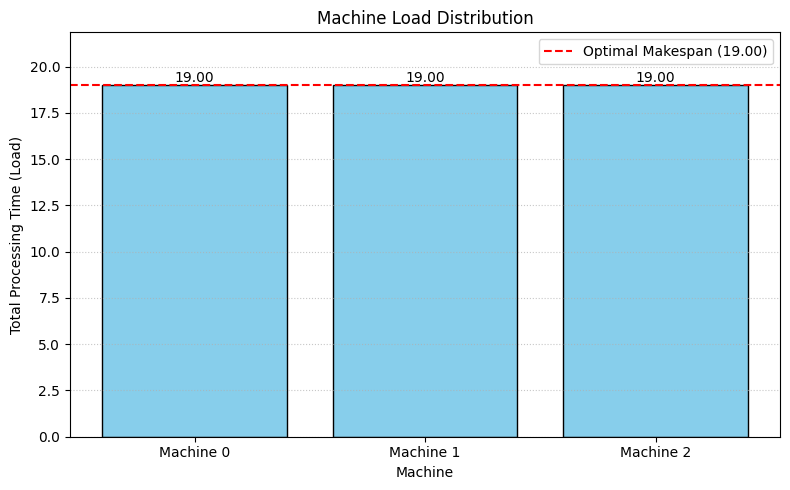


Generating Gantt-style assignment chart...


/var/folders/75/kxv4q45s3vv21rqmyth9036w0000gn/T/ipykernel_64735/3642470963.py:82: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  job_colors = plt.cm.get_cmap("tab20", num_jobs_instance)  # Distinct colors for jobs


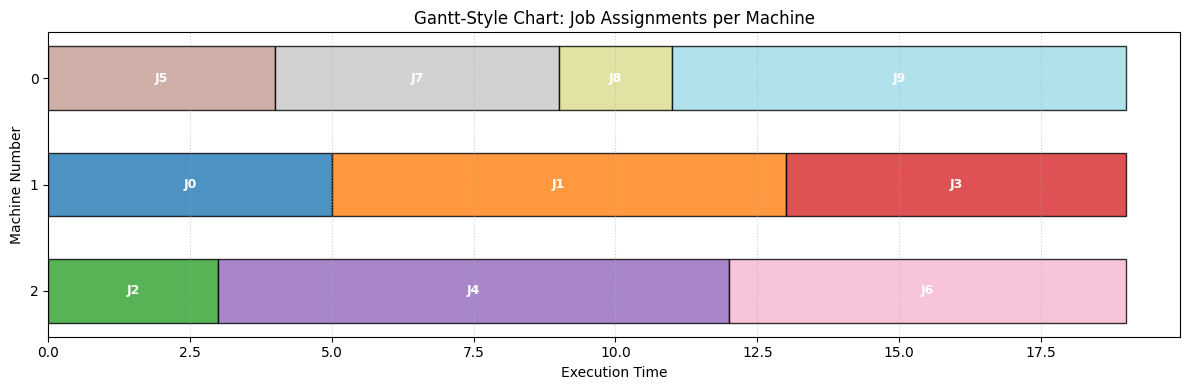

In [7]:
# Import plotting libraries if not already done
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd  # For the DataFrame display (assuming done in Sec 9)

num_machines_instance = instance_data["M"]
num_jobs_instance = len(instance_data["JT"])
job_times = instance_data["JT"]  # Alias for convenience

# --- Analysis: Calculate Machine Loads ---
print("\n--- Result Analysis ---")
print("Total Processing Time (Load) per Machine:")
machine_loads = {m: 0 for m in range(num_machines_instance)}
machine_load_list = []  # To store loads for plotting and verification

# Calculate loads directly from the 'assignment' dictionary
for m_idx in range(num_machines_instance):
    load = 0
    assigned_job_indices = assignment.get(m_idx, [])
    for job_idx in assigned_job_indices:
        if 0 <= job_idx < len(job_times):
            load += job_times[job_idx]
        else:
            print(
                f"Warning: Invalid job index {job_idx} found for machine {m_idx} during load calculation."
            )
    machine_loads[m_idx] = load
    machine_load_list.append(load)
    print(f"  Machine {m_idx}: {load:.2f}")

# --- Verification ---
calculated_max_load = max(machine_load_list) if machine_load_list else 0
print(f"\nCalculated Maximum Machine Load: {calculated_max_load:.2f}")
print(f"(Solver's Optimal Makespan: {optimal_makespan:.2f})")
# Use a small tolerance for float comparison
if abs(calculated_max_load - optimal_makespan) < 1e-6:
    print("-> Verification successful: Makespan matches the maximum machine load.")
else:
    print(
        "-> WARNING: Makespan does NOT match the calculated maximum load. Check model/solver."
    )

# --- Visualization 1: Bar chart of machine loads ---
print("\n--- Visualization ---")
plt.figure(figsize=(8, 5))
machines = [f"Machine {m}" for m in range(num_machines_instance)]
bars = plt.bar(machines, machine_load_list, color="skyblue", edgecolor="black")
plt.axhline(
    optimal_makespan,
    color="red",
    linestyle="--",
    label=f"Optimal Makespan ({optimal_makespan:.2f})",
)

for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        yval,
        f"{yval:.2f}",
        va="bottom",
        ha="center",
    )

plt.xlabel("Machine")
plt.ylabel("Total Processing Time (Load)")
plt.title("Machine Load Distribution")
plt.legend()
plt.grid(axis="y", linestyle=":", alpha=0.7)
plt.ylim(0, optimal_makespan * 1.15)
plt.tight_layout()
plt.show()

# --- Visualization 2: Gantt-Style Chart of Assignments ---
# This chart shows the jobs assigned to each machine sequentially.
# The horizontal axis represents time.
# Based on the user-provided snippet's logic.

fig, ax = plt.subplots(figsize=(12, max(4, num_machines_instance * 0.8)))
# Track the current end time for each machine
machine_end_times = np.zeros(num_machines_instance)
job_colors = plt.cm.get_cmap("tab20", num_jobs_instance)  # Distinct colors for jobs

print("\nGenerating Gantt-style assignment chart...")

# Iterate through machines and the jobs assigned to them
for m_idx in range(num_machines_instance):
    # Get assigned jobs for this machine, sort for consistent plotting (optional)
    assigned_job_indices = sorted(assignment.get(m_idx, []))

    for job_idx in assigned_job_indices:
        if 0 <= job_idx < len(job_times):
            job_time = job_times[job_idx]
            start_plot_time = machine_end_times[m_idx]

            # Plot the bar for the job
            ax.barh(
                m_idx,
                job_time,
                left=start_plot_time,
                height=0.6,
                align="center",
                color=job_colors(job_idx % job_colors.N),
                edgecolor="black",
                alpha=0.8,
            )

            # Add job index text inside the bar
            # Adjust text position slightly for better visibility
            text_x = start_plot_time + job_time / 2.0
            text_y = m_idx  # Vertically center within the bar's height
            ax.text(
                text_x,
                text_y,
                f"J{job_idx}",
                va="center",
                ha="center",
                color="white",
                fontweight="bold",
                fontsize=9,
            )

            # Update the end time for this machine
            machine_end_times[m_idx] += job_time
        else:
            # This condition should ideally not be met if extraction worked
            print(
                f"Skipping plotting for invalid job index {job_idx} on machine {m_idx}"
            )

# --- Configure plot appearance ---
ax.set_xlabel("Execution Time")
ax.set_ylabel("Machine Number")
# Set y-ticks to match machine indices
ax.set_yticks(range(num_machines_instance))
ax.set_yticklabels(
    [f"{m}" for m in range(num_machines_instance)]
)  # Label ticks with machine numbers
ax.set_title("Gantt-Style Chart: Job Assignments per Machine")

# Improve appearance
ax.invert_yaxis()  # Show Machine 0 at the top
plt.grid(axis="x", linestyle=":", alpha=0.6)
# Set x-axis limit slightly beyond makespan for clarity
plt.xlim(0, optimal_makespan * 1.05)
plt.tight_layout()
plt.show()


## 11. Summary

In this notebook, we demonstrated how to model and solve a **Parallel Machine Scheduling Problem (PMSP)** using JijModeling and the **OMMX SCIP Adapter**.

* We defined the problem: Assign independent jobs to identical parallel machines to minimize the makespan (maximum machine completion time).
* We formulated a mathematical model using JijModeling, defining binary variables `x[i, m]` for assignments and a continuous variable `makespan` for the objective.
* We included constraints ensuring each job is assigned exactly once and that the makespan correctly reflects the maximum load on any machine.
* We provided specific instance data (job processing times, number of machines).
* We used the `ommx-pyscipopt-adapter` to interpret the model and solve the instance using the SCIP solver.
* Finally, we extracted and interpreted the results from the solver's solution object, verifying the makespan against calculated machine loads, and visualized the assignments and loads using plots.

This process illustrates how mathematical optimization libraries like JijModeling can be combined with different solver interfaces (via OMMX adapters) to tackle practical scheduling challenges. The same principles can be extended to more complex problems.